In [10]:
import numpy as np
import matplotlib.pyplot as plt

from imageio import imread
from skimage.transform import resize
from scipy.ndimage.filters import convolve

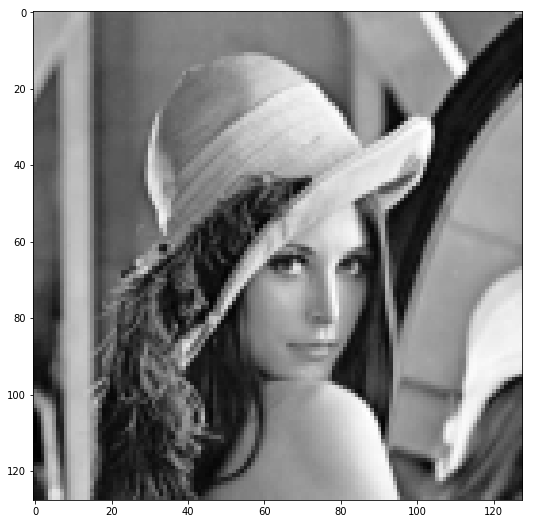

In [18]:
im = imread("lena.jpg", pilmode="L")
im = resize(im, (128,128), mode="reflect", anti_aliasing=True)
#print(im.shape)
#print(im)
#print(im.dtype)
im = (im * 255).astype(np.uint8)
#print(im.shape)
#print(im)
#print(im.shape)

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(im, cmap=plt.cm.gray)
plt.show()

# Exersice 2: Spatial Filtering (Convolution)

**Filtering** is a discrete convolution of an image $I$ with a filter mask $A \in \mathbb{R}^{m \times n}$:

$$
\begin{align}
 I_{A}       &= I * A \\
 I_{A}(i, j) &= \left(I * A\right)(i, j) \\
                                       &= \sum_{h=-\frac{m}{2}}^{\frac{m}{2}} \sum_{k=-\frac{n}{2}}^{\frac{n}{2}} A\left(h + \frac{m}{2} , k+\frac{n}{2}\right) \cdot I(i-h, j-k)
\end{align}
$$

Typically, the filter masks are square matrices, meaning $n=m$.
A special filter mask can be a **box filter**:

$$
\begin{align}
  B =%
  \dfrac{1}{9}\begin{pmatrix}
              1&1&1\\1&1&1\\1&1&1
             \end{pmatrix}.
\end{align}
$$

### Small Visualization

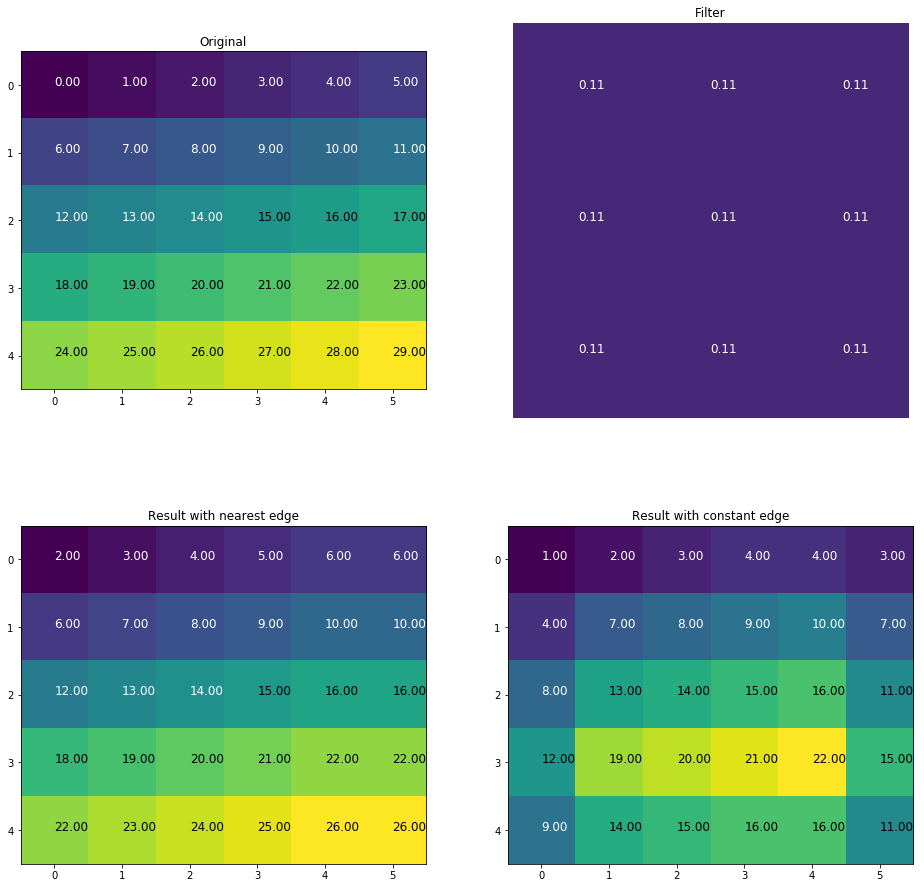

In [4]:
def display_with_values(im, ax=None, thresh=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(16,9))
        
    ax.imshow(im, **kwargs)

    it = np.nditer(im, flags=["multi_index"], op_flags=["readonly"])
    if thresh is None:
        thresh = im.mean()
        
    while not it.finished:
        y, x = it.multi_index
        val = it.value
        
        c = "black" if val > thresh else "white"
        ax.text(x,y, "{:^4.2f}".format(val), color=c, fontsize=12)
        it.iternext()
        
I = np.arange(30).reshape(5,6)
B = np.ones((3,3), dtype=np.float32)
B /= B.sum()

I_B_nearest = convolve(I, B, mode="nearest")
I_B_constant = convolve(I, B, mode="constant")

fig, axs = plt.subplots(2, 2, figsize=(16,16))

axs[0,0].set_title("Original")
display_with_values(I, ax=axs[0,0])

axs[0,1].set_title("Filter")
axs[0,1].axis("off")
display_with_values(B, ax=axs[0,1], thresh=0.5, vmin=0, vmax=1)

axs[1,0].set_title("Result with nearest edge")
display_with_values(I_B_nearest, ax=axs[1,0])

axs[1,1].set_title("Result with constant edge")
display_with_values(I_B_constant, ax=axs[1,1])

## Task 1 - Convolution Implementation

- Write a function, that applies an arbitrary (squared) filter to an image
- Is there any way to speed up your code?
- Test your code (possibly different implementations) and compare the runtimes
- Compare your implementation with the built-in method <code>scipy.ndimage.filters.convolve</code> (quality and runtime)

### Solution

In [19]:
def imfilter1(im, mask):
    h, w = im.shape
    m, n = mask.shape
    
    m_delta, n_delta = int((m-1) / 2), int((n-1) / 2)
    result = np.zeros(im.shape, dtype=np.float32)
    
    # Iterate over the image
    for y in range(h):
        for x in range(w):
            weighted_patch = np.zeros_like(mask)
            
            # Iterate over the filter mask
            for i in range(-m_delta, m_delta+1):
                for j in range(-n_delta, n_delta+1):
                    
                    # get "correct" coordinates in the weight mask
                    y_mask = i + m_delta
                    x_mask = j + n_delta

                    # compute for each position of the weight
                    # according coordinates in input image
                    y_src = min(max(y + i, 0), h - 1)
                    x_src = min(max(x + j, 0), w - 1)
                    
                    # get pixel and the mask weight and ...
                    pixel = im[y_src, x_src]
                    weight = mask[y_mask, x_mask]
                    weighted_patch[y_mask, x_mask] = pixel * weight
                    
            # ... sum it up in the result image
            result[y,x] = weighted_patch.sum()
    return result.astype(im.dtype)

In [6]:
def imfilter2(im, mask, mode="edge"):
    
    h, w = im.shape
    m, n = mask.shape
    
    m_delta, n_delta = int((m-1) / 2), int((n-1) / 2)
    result = np.zeros(im.shape, dtype=np.float32)
    
    # extend (pad) the image
    im_padded = np.pad(im, [(m_delta, m_delta), (n_delta, n_delta)], mode=mode)
    new_h, new_w = im_padded.shape
    
    for y in np.arange(h) + m_delta:
        for x in np.arange(w) + n_delta:
            
            # compute the extents of our current image are
            x0, x1 = x - n_delta, x + n_delta + 1
            y0, y1 = y - n_delta, y + n_delta + 1
            
            # compute the output coordinates
            x_out = x - n_delta
            y_out = y - m_delta
            
            # get the image patch and weight it with the mask values
            im_patch = im_padded[y0:y1, x0:x1] * mask
            
            # store the sum of weighted pixel in the result image
            result[y_out, x_out] = im_patch.sum()
    return result.astype(im.dtype)

In [7]:
I = im.copy()
size = 3
B = np.ones((size, size), np.float32) / size**2

print("imfilter1")
%time I1 = imfilter1(I, B)

print("imfilter2")
%time I2 = imfilter2(I, B)

print("convolve")
%time I3 = convolve(I, B)

imfilter1
CPU times: user 1.04 s, sys: 24.3 ms, total: 1.06 s
Wall time: 1.06 s
imfilter2
CPU times: user 197 ms, sys: 1.76 ms, total: 198 ms
Wall time: 202 ms
convolve
CPU times: user 830 µs, sys: 89 µs, total: 919 µs
Wall time: 581 µs


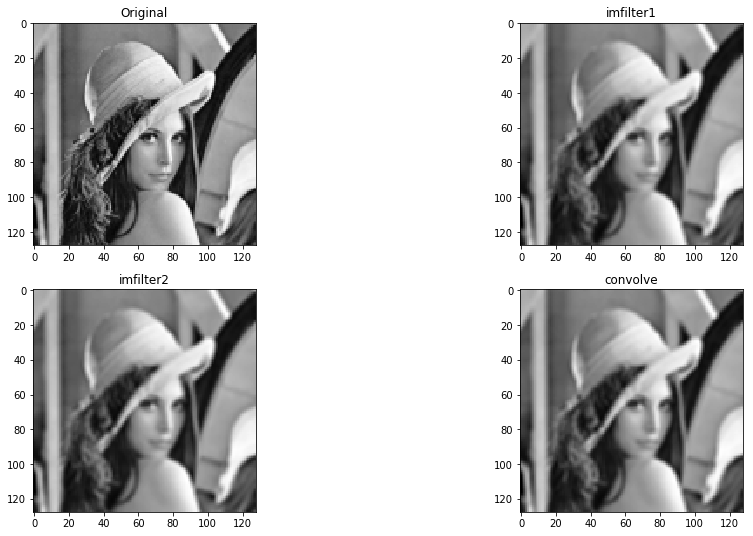

In [8]:
fig, axs = plt.subplots(2,2, figsize=(16,9))

axs[0,0].imshow(I, cmap=plt.cm.gray)
axs[0,0].set_title("Original")

axs[0,1].imshow(I1, cmap=plt.cm.gray)
axs[0,1].set_title("imfilter1")

axs[1,0].imshow(I2, cmap=plt.cm.gray)
axs[1,0].set_title("imfilter2")

axs[1,1].imshow(I3, cmap=plt.cm.gray)
axs[1,1].set_title("convolve")

plt.show()

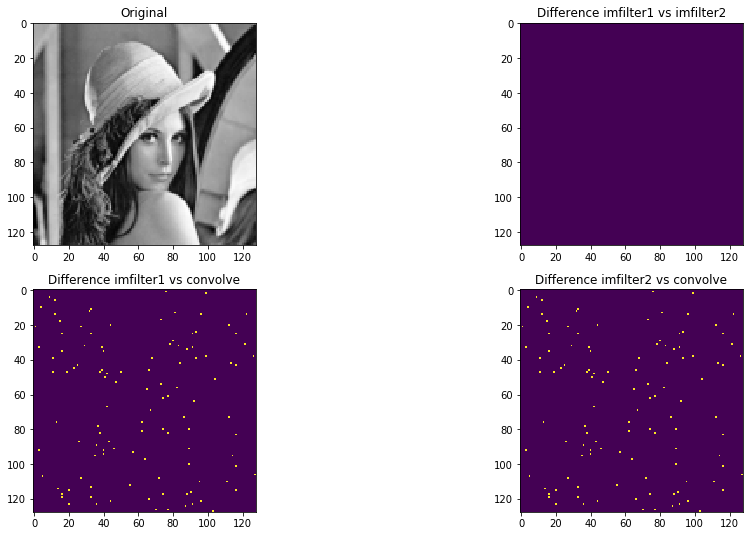

In [209]:
fig, axs = plt.subplots(2,2, figsize=(16,9))

axs[0,0].imshow(I, cmap=plt.cm.gray)
axs[0,0].set_title("Original")

axs[0,1].imshow(np.abs(I1-I2), vmin=0, vmax=255)
axs[0,1].set_title("Difference imfilter1 vs imfilter2")

axs[1,0].imshow(np.abs(I1-I3), vmin=0, vmax=255)
axs[1,0].set_title("Difference imfilter1 vs convolve")

axs[1,1].imshow(np.abs(I2-I3), vmin=0, vmax=255)
axs[1,1].set_title("Difference imfilter2 vs convolve")

plt.show()